In [1]:
 # Automatic Ticket Assignment - Capstone Project - Approach2
# 
# ## Problem Statement - 
# 
# In most of the IT organizations, the assignment of incidents to appropriate IT groups is still a manual process. Manual assignment of incidents is time consuming and requires human efforts. There may be mistakes due to human errors and resource consumption is carried out ineffectively because of the misaddressing. On the other hand, manual assignment increases the response and resolution times which result in user satisfaction deterioration / poor customer service. 
# 
# _<font color=blue>This capstone project intends to reduce the manual intervention of IT operations or Service desk teams by automating the ticket assignment process.The goal here is to create a text classification based ML model that can automatically  classify any new tickets by analysing ticket description to one of the relevant Assignment groups, which could be later integrated to any ITSM tool like Service Now. Based on the ticket description our model will output the probability of assigning it to one of the 74 Groups.</font>_
# 
# The solution would be implemented using below approach:
# 
# In the AS-IS process it's mentioned that around ~54% of the incidents are resolved by L1 / L2 teams and the rest will be resolved as L3. So the assumption is that GRP_0 and GRP_8 which contribute 54% of the tickets are related to L1/L2 teams and the rest of the tickets belongs to L3 teams
# 
# So firstly, the ticket would be classified into L1/L2 or L3 classes and then it would be further classified into one of the given assignment groups. 


In [2]:
import pandas as pd
import numpy as np
import re
import string

from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier


from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import warnings 
warnings.filterwarnings('ignore')

In [3]:

df_incidents_level = pd.read_csv('../dataset/cleaned_data.csv',encoding='utf-8')
df_incidents_level.head()

,Description,Assignment group,cleaned_description,num_wds,avg_word,uniq_wds,token_desc
0,-verified user details.(employee# & manager na...,GRP_0,login issueverified user detailsemployee manag...,18,7.555556,15,login issueverified user detailsemployee manag...
1,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,GRP_0,outlook hmjdrvpbkomuaywn teammy meetingsskype ...,13,7.538462,12,outlook hmjdrvpbkomuaywn teammy meetingsskype ...
2,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,GRP_0,cant log vpn eylqgodmybqkwiami cannot log vpn,7,5.571429,5,cant log vpn eylqgodmybqkwiami cannot log vpn
3,unable to access hr_tool page,GRP_0,unable access hrtool pageunable access hrtool ...,7,6.285714,5,unable access hrtool pageunable access hrtool ...
4,skype error,GRP_0,skype error skype error,4,5.000000,2,skype error skype error


In [5]:
df_incidents_level.rename(columns={'Assignment group':'Assignment_group'},inplace=True)

In [8]:
df_incidents_level.head()
# Since the dataset is very imbalanced, we will be considering a subset of groups for predictions. In 74 groups, 46% of tickets belong to group 1 and 16 groups have more than 100 tickets and around 22 groups have more than 50 tickets, rest of the Assignment groups have very less ticket counts which might not add much value to the model prediction. If we conducted random sampling towards all the subcategories, then we would face a problem that we might miss all the tickets in some categories. Hence, we considered the groups that have more than 50 tickets in this appoach


,Description,Assignment_group,cleaned_description,num_wds,avg_word,uniq_wds,token_desc
0,-verified user details.(employee# & manager na...,GRP_0,login issueverified user detailsemployee manag...,18,7.555556,15,login issueverified user detailsemployee manag...
1,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,GRP_0,outlook hmjdrvpbkomuaywn teammy meetingsskype ...,13,7.538462,12,outlook hmjdrvpbkomuaywn teammy meetingsskype ...
2,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,GRP_0,cant log vpn eylqgodmybqkwiami cannot log vpn,7,5.571429,5,cant log vpn eylqgodmybqkwiami cannot log vpn
3,unable to access hr_tool page,GRP_0,unable access hrtool pageunable access hrtool ...,7,6.285714,5,unable access hrtool pageunable access hrtool ...
4,skype error,GRP_0,skype error skype error,4,5.000000,2,skype error skype error


In [10]:
df_incidents_level = df_incidents_level[df_incidents_level['Assignment_group'].map(df_incidents_level['Assignment_group'].value_counts()) > 50]

df_incidents_level['Target'] = np.where(df_incidents_level['Assignment_group']=='GRP_0','L1/L2',np.where(df_incidents_level['Assignment_group'] =='GRP_8','L1/L2','L3'))
x = df_incidents_level['token_desc']
y = df_incidents_level['Target']
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
# encoding train labels 
encoder.fit(y)
y = encoder.transform(y)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=13,stratify=y)
from sklearn.utils.class_weight import compute_class_weight


In [12]:
from sklearn.utils.class_weight import compute_class_weight


In [13]:
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights

array([0.8336489 , 1.24929064])

In [16]:
w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val]
    
    
log_cols=["Classifier", "accuracy","f1_score"]
log1 = pd.DataFrame(columns=log_cols)

In [17]:
log1

,Classifier,accuracy,f1_score


In [18]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota


In [19]:
# ### Modeling
# 
# Pass the data to various models which learns to classify the tickets into one of the two groups -  L1/L2 or L3 class

# #### Multinomial Naive Bayes

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

predictions = nb.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test)) 
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))


log_entry = pd.DataFrame([["MultinomialNB",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log1 = log1.append(log_entry)



accuracy 0.7800129785853342
f1 score 0.7945710081662295
logloss: 0.431 
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       924
           1       0.88      0.53      0.66       617

    accuracy                           0.78      1541
   macro avg       0.81      0.74      0.75      1541
weighted avg       0.80      0.78      0.77      1541

[[878  46]
 [293 324]]


In [22]:
# #### Linear SVC


In [23]:
from sklearn.svm import LinearSVC

svc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(LinearSVC(loss='hinge',random_state=42,class_weight='balanced'))),
               ])
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 


print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))
log_entry = pd.DataFrame([["LinearSVC",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log1 = log1.append(log_entry)




accuracy 0.8027255029201817
f1 score 0.8010106025644771
              precision    recall  f1-score   support

           0       0.87      0.78      0.83       924
           1       0.72      0.83      0.77       617

    accuracy                           0.80      1541
   macro avg       0.80      0.81      0.80      1541
weighted avg       0.81      0.80      0.80      1541

[[724 200]
 [104 513]]


In [24]:
# #### SGD Classifier


In [25]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=100, tol=None,class_weight='balanced')),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 


print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["SGDClassifier",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log1 = log1.append(log_entry)


accuracy 0.755353666450357
f1 score 0.7536760729524584
              precision    recall  f1-score   support

           0       0.90      0.67      0.77       924
           1       0.64      0.89      0.74       617

    accuracy                           0.76      1541
   macro avg       0.77      0.78      0.75      1541
weighted avg       0.80      0.76      0.76      1541

[[616 308]
 [ 69 548]]


In [26]:
# #### Logistic Regression


In [27]:
from sklearn.linear_model import LogisticRegression

logreg_1 = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5,class_weight='balanced')),
               ])
logreg_1.fit(X_train, y_train)

y_pred = logreg_1.predict(X_test)
predictions = logreg_1.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["LogisticRegression",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log1 = log1.append(log_entry)



accuracy 0.7657365347177157
f1 score 0.7636674268416505
logloss: 1.877 
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       924
           1       0.68      0.79      0.73       617

    accuracy                           0.77      1541
   macro avg       0.76      0.77      0.76      1541
weighted avg       0.78      0.77      0.77      1541

[[694 230]
 [131 486]]


In [28]:
log1.set_index(["Classifier"],inplace=True)
log1.sort_values(by=['f1_score'])


,accuracy,f1_score
Classifier,,
SGDClassifier,0.755354,0.753676
LogisticRegression,0.765737,0.763667
MultinomialNB,0.780013,0.794571
LinearSVC,0.802726,0.801011


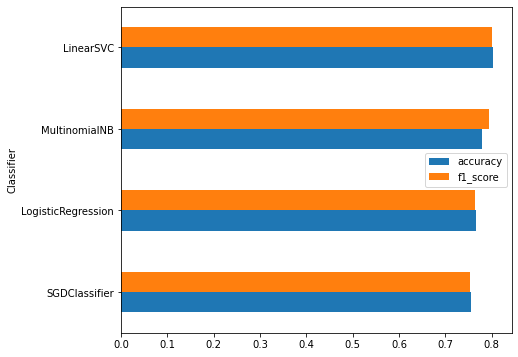

In [29]:
log1.sort_values(by=['f1_score']).plot(kind='barh',figsize=[7,6])


In [30]:
# Linear SVC gives better performance compared to other models


In [33]:
### Save the model
# from sklearn.externals import joblib
import sklearn.externals
import joblib
joblib.dump(svc, 'l1_l2_classification.pkl', compress=1)

['l1_l2_classification.pkl']

In [34]:

le_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
le_name_mapping


{'L1/L2': 0, 'L3': 1}

In [35]:
import joblib

model = joblib.load('l1_l2_classification.pkl')

sentence = 'job failed in scheduler'
encoder.inverse_transform(model.predict([sentence]))


array(['L1/L2'], dtype=object)

In [36]:
df_incidents_l1_l2 = df_incidents_level[df_incidents_level['Target'] == 'L1/L2']
df_incidents_l1_l2.shape



(4621, 8)

In [37]:
df_incidents_l1_l2.Assignment_group.value_counts()


GRP_0    3960
GRP_8     661
Name: Assignment_group, dtype: int64

In [38]:
x = df_incidents_l1_l2['token_desc']
y = df_incidents_l1_l2['Assignment_group']


In [39]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
# encoding train labels 
encoder.fit(y)
y = encoder.transform(y)


In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=13,stratify=y)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights

w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val]
    
    
log_cols=["Classifier", "accuracy","f1_score"]
log2 = pd.DataFrame(columns=log_cols)


In [41]:
# ### Naive Bayes



from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report


nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


y_pred = nb.predict(X_test)
predictions = nb.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test)) 
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))


log_entry = pd.DataFrame([["MultinomialNB",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log2 = log2.append(log_entry)

accuracy 0.9881081081081081
f1 score 0.9883256723277415
logloss: 0.044 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       793
           1       1.00      0.92      0.96       132

    accuracy                           0.99       925
   macro avg       0.99      0.96      0.97       925
weighted avg       0.99      0.99      0.99       925

[[793   0]
 [ 11 121]]


In [42]:
# ### Linear Support Vector Machine



from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier


svc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(LinearSVC(loss='hinge',random_state=42,class_weight='balanced'))),
               ])
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print('Test accuracy %s' % accuracy_score(y_pred, y_test))
print('Test f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["LinearSVC",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log2 = log2.append(log_entry)



Test accuracy 0.9913513513513513
Test f1 score 0.9914647834785852
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       793
           1       1.00      0.94      0.97       132

    accuracy                           0.99       925
   macro avg       1.00      0.97      0.98       925
weighted avg       0.99      0.99      0.99       925

[[793   0]
 [  8 124]]


In [43]:
# ### SGD Classifier



from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=100, tol=None,class_weight='balanced')),
               ])
sgd.fit(X_train, y_train)




y_pred = sgd.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 


print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))


log_entry = pd.DataFrame([["SGDClassifier",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log2 = log2.append(log_entry)


accuracy 0.9902702702702703
f1 score 0.9904145207350075
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       793
           1       1.00      0.93      0.96       132

    accuracy                           0.99       925
   macro avg       0.99      0.97      0.98       925
weighted avg       0.99      0.99      0.99       925

[[793   0]
 [  9 123]]


In [44]:
# ### Logistic Regression



from sklearn.linear_model import LogisticRegression

logreg_1 = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5,class_weight='balanced')),
               ])
logreg_1.fit(X_train, y_train)

y_pred = logreg_1.predict(X_test)
predictions = logreg_1.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["LogisticRegression",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log2 = log2.append(log_entry)


accuracy 0.9913513513513513
f1 score 0.9914647834785852
logloss: 0.054 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       793
           1       1.00      0.94      0.97       132

    accuracy                           0.99       925
   macro avg       1.00      0.97      0.98       925
weighted avg       0.99      0.99      0.99       925

[[793   0]
 [  8 124]]


In [45]:
log2.set_index(["Classifier"],inplace=True)
log2.sort_values(by=['f1_score'])


,accuracy,f1_score
Classifier,,
MultinomialNB,0.988108,0.988326
SGDClassifier,0.990270,0.990415
LinearSVC,0.991351,0.991465
LogisticRegression,0.991351,0.991465


In [48]:
### Save the model
import joblib
joblib.dump(logreg_1, 'model_l1_l2.pkl', compress=1)


['model_l1_l2.pkl']

In [49]:
le_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
le_name_mapping


{'GRP_0': 0, 'GRP_8': 1}

In [51]:
import joblib
model = joblib.load('model_l1_l2.pkl')

sentence = 'job failed in scheduler'
encoder.inverse_transform(model.predict([sentence]))

array(['GRP_8'], dtype=object)

In [52]:
# ## Model to classify L3 tickets
# 
# Lets's now train the models to classify the L3 tickets into one of the assignement groups.


In [53]:
df_incidents_l3 = df_incidents_level[df_incidents_level['Target'] == 'L3']
df_incidents_l3 = df_incidents_l3[df_incidents_l3['Assignment_group'].map(df_incidents_l3['Assignment_group'].value_counts()) > 50]
x = df_incidents_l3['token_desc']
y = df_incidents_l3['Assignment_group']

from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
# encoding train labels 
encoder.fit(y)
y = encoder.transform(y)

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=13,stratify=y)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights

w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val]
    
log_cols=["Classifier", "accuracy","f1_score"]
log = pd.DataFrame(columns=log_cols)


In [55]:
# ### Naive Bayes



from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report


nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


y_pred = nb.predict(X_test)
predictions = nb.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test)) 
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["MultinomialNB",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)


accuracy 0.47649918962722854
f1 score 0.5555073395313899
logloss: 1.909 
              precision    recall  f1-score   support

           0       0.75      0.11      0.19        28
           1       0.53      0.83      0.65        52
           2       0.62      0.62      0.62        29
           3       1.00      0.12      0.22        24
           4       0.00      0.00      0.00        17
           5       0.94      1.00      0.97        16
           6       0.00      0.00      0.00        18
           7       0.41      0.63      0.50        43
           8       0.35      0.96      0.51        48
           9       0.64      0.97      0.77        58
          10       1.00      0.26      0.41        23
          11       0.00      0.00      0.00        11
          12       0.50      0.05      0.10        19
          13       0.37      0.42      0.40        40
          14       0.00      0.00      0.00        11
          15       1.00      0.14      0.25        21
        

In [56]:
# ### Linear Support Vector Machine



from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier


svc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(LinearSVC(loss='hinge',random_state=42,class_weight='balanced'))),
               ])
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print('Test accuracy %s' % accuracy_score(y_pred, y_test))
print('Test f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["LinearSVC",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)


Test accuracy 0.593192868719611
Test f1 score 0.5999503491225455
              precision    recall  f1-score   support

           0       0.26      0.82      0.39        28
           1       0.68      0.77      0.72        52
           2       0.55      0.59      0.57        29
           3       0.55      0.50      0.52        24
           4       0.81      0.76      0.79        17
           5       1.00      1.00      1.00        16
           6       0.63      0.67      0.65        18
           7       0.47      0.58      0.52        43
           8       0.62      0.83      0.71        48
           9       0.94      0.86      0.90        58
          10       0.82      0.61      0.70        23
          11       0.62      0.45      0.53        11
          12       0.68      0.68      0.68        19
          13       0.40      0.47      0.44        40
          14       0.36      0.36      0.36        11
          15       0.61      0.52      0.56        21
          16    

In [57]:
# ### SGD Classifier



from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=100, tol=None,class_weight='balanced')),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 


print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["SGDClassifier",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)



accuracy 0.5380875202593193
f1 score 0.535327001211682
              precision    recall  f1-score   support

           0       0.50      0.21      0.30        28
           1       0.88      0.58      0.70        52
           2       0.18      0.66      0.28        29
           3       0.50      0.54      0.52        24
           4       0.50      0.82      0.62        17
           5       0.94      1.00      0.97        16
           6       0.54      0.72      0.62        18
           7       0.61      0.47      0.53        43
           8       0.65      0.62      0.64        48
           9       0.94      0.84      0.89        58
          10       0.76      0.70      0.73        23
          11       0.35      0.64      0.45        11
          12       0.54      0.68      0.60        19
          13       0.60      0.38      0.46        40
          14       0.20      0.27      0.23        11
          15       0.52      0.57      0.55        21
          16       0.27   

In [59]:
# ### Logistic Regression

from sklearn.linear_model import LogisticRegression

logreg_1 = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5,class_weight='balanced')),
               ])
logreg_1.fit(X_train, y_train)

y_pred = logreg_1.predict(X_test)
predictions = logreg_1.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["LogisticRegression",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols)
log = log.append(log_entry)



accuracy 0.5769854132901134
f1 score 0.5705393030481682
logloss: 2.409 
              precision    recall  f1-score   support

           0       0.64      0.25      0.36        28
           1       0.71      0.77      0.74        52
           2       0.67      0.55      0.60        29
           3       0.68      0.54      0.60        24
           4       0.72      0.76      0.74        17
           5       1.00      1.00      1.00        16
           6       0.55      0.67      0.60        18
           7       0.44      0.58      0.50        43
           8       0.57      0.71      0.63        48
           9       0.91      0.86      0.88        58
          10       0.88      0.61      0.72        23
          11       0.62      0.45      0.53        11
          12       0.60      0.47      0.53        19
          13       0.47      0.55      0.51        40
          14       0.26      0.45      0.33        11
          15       0.73      0.52      0.61        21
         

In [61]:
log.set_index(["Classifier"],inplace=True)
log.sort_values(by=['f1_score'])



,accuracy,f1_score
Classifier,,
SGDClassifier,0.538088,0.535327
MultinomialNB,0.476499,0.555507
LogisticRegression,0.576985,0.570539
LogisticRegression,0.576985,0.570539
LinearSVC,0.593193,0.599950


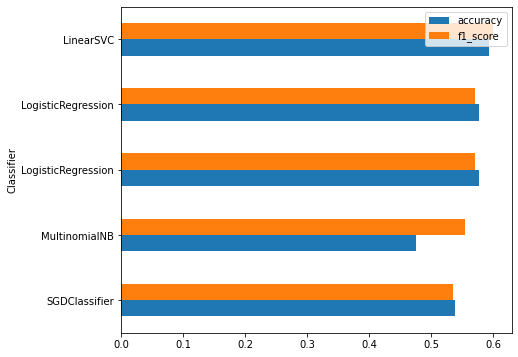

In [62]:
log.sort_values(by=['f1_score']).plot(kind='barh',figsize=[7,6])


In [63]:
 ## Hyperparameter Tune GridSearchCV 
# 
# Let's tune each of the models using GridsearchCV to identify the best parameters


In [65]:
# ### Linear SVC




from sklearn.model_selection import GridSearchCV

params = {"clf__estimator__C": [0.1, 1, 10, 100, 1000],  
              'clf__estimator__loss': ['hinge','squared_hinge'],}  
  
clf_svc = GridSearchCV(svc, param_grid=params, refit = True, verbose = 1,scoring='f1_weighted') 
# fitting the model for grid search 
clf_svc.fit(X_train, y_train)

print("Best Score: ", clf_svc.best_score_)
print("Best Params: ", clf_svc.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   23.8s finished


Best Score:  0.5864182764039391
Best Params:  {'clf__estimator__C': 1, 'clf__estimator__loss': 'squared_hinge'}


In [66]:
y_pred = clf_svc.best_estimator_.predict(X_test)
#predictions = clf_svc.best_estimator_.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
#print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["LinearSVC_best_estimator",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols,index=['LinearSVC_best_estimator'])
log = log.append(log_entry)


accuracy 0.593192868719611
f1 score 0.5913354430373698
              precision    recall  f1-score   support

           0       0.57      0.29      0.38        28
           1       0.69      0.79      0.74        52
           2       0.57      0.59      0.58        29
           3       0.57      0.54      0.55        24
           4       0.81      0.76      0.79        17
           5       1.00      1.00      1.00        16
           6       0.55      0.67      0.60        18
           7       0.46      0.58      0.52        43
           8       0.62      0.83      0.71        48
           9       0.94      0.84      0.89        58
          10       0.81      0.57      0.67        23
          11       0.62      0.45      0.53        11
          12       0.68      0.68      0.68        19
          13       0.49      0.50      0.49        40
          14       0.33      0.36      0.35        11
          15       0.63      0.57      0.60        21
          16       0.20   

In [67]:
# ### SGD Classifier




params = {
    "clf__loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "clf__alpha" : [0.0001, 0.001, 0.01, 0.1],
    "clf__penalty" : ["l2", "l1", "none"],
}

clf_sgd = GridSearchCV(sgd, param_grid=params,refit = True, verbose = 1,scoring='f1_weighted')
clf_sgd.fit(X_train, y_train)

print("Best Score: ", clf_sgd.best_score_)
print("Best Params: ", clf_sgd.best_params_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.6min finished


Best Score:  0.5911779636488127
Best Params:  {'clf__alpha': 0.0001, 'clf__loss': 'log', 'clf__penalty': 'l2'}


In [68]:
y_pred = clf_sgd.best_estimator_.predict(X_test)
#predictions = clf_svc.best_estimator_.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
#print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["SGD_best_estimator",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols,index=['SGD_best_estimator'])
log = log.append(log_entry)

accuracy 0.6142625607779578
f1 score 0.6250327734532034
              precision    recall  f1-score   support

           0       0.70      0.25      0.37        28
           1       0.74      0.71      0.73        52
           2       0.51      0.66      0.58        29
           3       0.61      0.58      0.60        24
           4       0.65      0.76      0.70        17
           5       0.94      1.00      0.97        16
           6       0.55      0.61      0.58        18
           7       0.55      0.56      0.55        43
           8       0.72      0.79      0.75        48
           9       0.94      0.86      0.90        58
          10       0.83      0.65      0.73        23
          11       0.46      0.55      0.50        11
          12       0.62      0.68      0.65        19
          13       0.44      0.53      0.48        40
          14       0.38      0.45      0.42        11
          15       0.58      0.67      0.62        21
          16       0.25  

In [69]:
# ### Logistic Regression



params = {
  'clf__penalty': ['l2'],
  'clf__C': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0,1e2,1e4,1e5],
  'clf__max_iter': [100,4000,5000],
}

clf_lr = GridSearchCV(logreg_1, param_grid=params,refit = True,verbose = 1,scoring='f1_weighted')
clf_lr.fit(X_train, y_train)

print("Best Score: ", clf_lr.best_score_)
print("Best Params: ", clf_lr.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 16.5min finished


Best Score:  0.5825739734316713
Best Params:  {'clf__C': 100.0, 'clf__max_iter': 4000, 'clf__penalty': 'l2'}


In [70]:
y_pred = clf_lr.best_estimator_.predict(X_test)
#predictions = clf_svc.best_estimator_.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print('f1 score %s' % f1_score(y_pred, y_test,average='weighted')) 
#print ("logloss: %0.3f " % multiclass_logloss(y_test,predictions))

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

log_entry = pd.DataFrame([["LogisticRegression_best_estimator",accuracy_score(y_pred, y_test),f1_score(y_pred, y_test,average='weighted')]], columns=log_cols,index=['LogisticRegression_best_estimator'])
log = log.append(log_entry)


accuracy 0.580226904376013
f1 score 0.5757777878445178
              precision    recall  f1-score   support

           0       0.73      0.29      0.41        28
           1       0.68      0.77      0.72        52
           2       0.56      0.66      0.60        29
           3       0.57      0.50      0.53        24
           4       0.72      0.76      0.74        17
           5       1.00      1.00      1.00        16
           6       0.57      0.67      0.62        18
           7       0.48      0.56      0.52        43
           8       0.61      0.75      0.67        48
           9       0.94      0.84      0.89        58
          10       0.88      0.61      0.72        23
          11       0.60      0.55      0.57        11
          12       0.67      0.63      0.65        19
          13       0.43      0.50      0.46        40
          14       0.24      0.45      0.31        11
          15       0.67      0.57      0.62        21
          16       0.17   

In [71]:
log.sort_values(by=['f1_score'])


,accuracy,f1_score,Classifier
SGDClassifier,0.538088,0.535327,NaN
MultinomialNB,0.476499,0.555507,NaN
LogisticRegression,0.576985,0.570539,NaN
LogisticRegression,0.576985,0.570539,NaN
LogisticRegression_best_estimator,0.580227,0.575778,LogisticRegression_best_estimator
LinearSVC_best_estimator,0.593193,0.591335,LinearSVC_best_estimator
LinearSVC,0.593193,0.599950,NaN
SGD_best_estimator,0.614263,0.625033,SGD_best_estimator


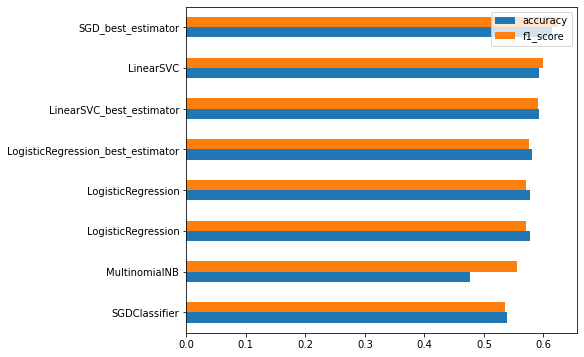

In [72]:
log.sort_values(by=['f1_score']).plot(kind='barh',figsize=[7,6])


In [73]:
from tensorflow import keras


class FocalLoss(keras.losses.Loss):
    def __init__(self, gamma=2., alpha=4.,
                 reduction=keras.losses.Reduction.AUTO, name='focal_loss'):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        """
        super(FocalLoss, self).__init__(reduction=reduction,
                                        name=name)
        self.gamma = float(gamma)
        self.alpha = float(alpha)

    def call(self, y_true, y_pred):
        """
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(
            tf.subtract(1., model_out), self.gamma))
        fl = tf.multiply(self.alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return reduced_fl


In [74]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
import tensorflow as tf

x = df_incidents_l3['token_desc']
y = df_incidents_l3['Assignment_group']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state=13,stratify=y)

num_labels = 22
vocab_size = 50000
batch_size = 64
 
# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
 
x_train = tokenizer.texts_to_matrix(X_train, mode='tfidf')
x_test = tokenizer.texts_to_matrix(X_test, mode='tfidf')

encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


Using TensorFlow backend.


ImportError: cannot import name 'parse_version'

In [ ]:

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model = Sequential()
model.add(Dense(50, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(30))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()
 
model.compile(loss=FocalLoss(alpha=1),
              optimizer='nadam',
              metrics=['accuracy'])
 
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=30,
                    verbose=1,validation_split=0.2,callbacks=[es_callback])


# In[ ]:


score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
 
print('Test accuracy:', score[1])



In [ ]:
import joblib
joblib.dump(clf_lr.best_estimator_, 'model_l3.pkl', compress=1)


In [ ]:
# # Finals Conclusions fo Approach2
# 
# - We first analysed the dataset provided to us, undestood the structure of the data provided - number of columns, field , datatypes etc.
# - We did Exploratory Data Analysis to derive further insights from this data set and we found that
#     - Data is very much imbalanced, there are around ~45% of the Groups with less than 20 tickets.
#     - Few of the tickets are in foreign language like German
#     - The data has lot of noise in it, for eg- few tickets related to account setup are spread across multiple assignment groups.
#     
# - We performed the data cleaning and preprocessing
#     - Translation: A small number of tickets were written in German. Hence, we used the Google translate python api  to convert German to English to generate the input data for the next steps. However, the google translator rest api can only process a limited number of texts on a daily basis, so we translated the text in batches and saved the file for further processing.
#     - Make text all lowercase so that the algorithm does not treat the same words in different cases as different
#     - Removing Noise i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values
#     - Removing extract spaces
#     - Removed punctuations
#     - Removed words containing numbers
#     - Stopword Removal: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words
#     - Lemmatization
#     - Tokenization: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.
#     
# 
# - We then ran a basic benchmarck model using the cleaned and preprocessed dataset
#     - Since the dataset is very imbalanced, We considered a subset of groups for predictions.  In 74 groups, 46% of tickets belong to group 1 and 16 groups just have more than 100 tickets, rest of the Assignment groups have very less ticket counts which might not add much value to the model prediction. If we conducted random sampling towards all the subcategories, then we would face a problem that we might miss all the tickets in some categories. Hence, we considered the groups that have more than 100 tickets. 
#     - We trained the data using below models:
#         - Multinomial NB
#         - Linear Support vector Machine
#         - Logistic regression
#         - Xgboost
#         
# -  LinearSVC gives better performance with 
#     accuracy 0.833642
#     f1 score 0.818053
# 
# <b> Although, it seems like the call is biased towards GRP_0 which has a majority of samples. </b>
# 
# 
# 
# 
# 
# - Even after downsampling the data we see that the predictions are biased towards GRP_0 which has a majority of samples.
# - Imbalance causes two problems:
#     - Training is inefficient as most samples are easy examples that contribute no useful learning signal;
#     - The easy examples can overwhelm training and lead to degenerate models.
#     A common solution is to perform some form of hard negative mining that samples hard examples during training or more complex sampling/re weighing schemes.In order to handle the imbalance problem  we used class_weight=balanced hyperparameter while training the model, which tells the model to "pay more attention" to samples from an under-represented class.  
# - Although, the accuracy and f1_score went down. This ensured that the classes were being correctly classified with lesser number of missclassification and good precision/recall scores for all the classes
# 
# - Next, we used Approach 2 where the ticket would be classified into L1/L2 or L3 classes and then it would be further classified into one of the given assignment groups. 
# 
# - We first created a model to classify the given tickets as l1/l2 or l3 ticket, we found that Linear SVC was giving a better score.
# - Next, another model was trained considering only l1/l2 level of incidents consisting of GRP_0 and GRP_8.
# - Finally, a third model was trained considering l3 level of tickets.
# 
# - We also used hyperparameter tuning, to identify the best classifier with best parameters. We found that LinearSVC was performing the best among all the other classifiers.
# - We also tried keras implementation with focal loss as a loss function to handle the class imbalance problem, which helps in giving more weightage to groups will less samples, but the results were not satifactory.
#   
#  - Finally, Logistic Regression gave better performance with hyperparameter tuning and this model would be used for classifying the L3 tickets into one of the groups.
#     - accuracy 0.706260
#     - f1 score 0.705392
# 
# 
# The performance can be further improved by collecting more data for tickets and by running deep learning models like RNN and LSTM's.